In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime
from torch.utils.data import dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import torchvision.transforms as transforms

In [2]:
logWriter = SummaryWriter("runs")

In [3]:
transformTrain = transforms.Compose(
    [
     transforms.RandomRotation(degrees = 45), 
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
transformTest = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
trainSet = datasets.CIFAR10(root = './data', train = True, download = True, transform = transformTrain)
testSet = datasets.CIFAR10(root = './data', train = False, download = True, transform = transformTest)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
batchSize = 16
trainLoader = DataLoader(dataset = trainSet, batch_size = batchSize, shuffle = True)
testLoader = DataLoader(dataset = testSet, batch_size = batchSize, shuffle = True)

In [7]:
itr = iter(trainLoader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

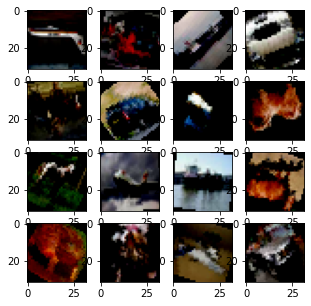

In [9]:
fig, ax = plt.subplots(4, 4, figsize=(5,5))

for i in range(4) :
    for j in range(4) :
        ax[i, j].imshow(itr.next()[0][i * 4 + j].permute(1, 2, 0))


In [12]:
print(itr.next()[0][0].shape)

torch.Size([3, 32, 32])


In [13]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.batchNormInput = nn.BatchNorm2d(3, affine=False)
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1)
        self.batchNorm1 = nn.BatchNorm2d(64, affine=False)
        self.conv2 = nn.Conv2d(64, 64, 3, stride=1, padding = 3)
        self.batchNorm2 = nn.BatchNorm2d(64, affine=False)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding = 1)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(1152, 500)  # 5*5 from image dimension
        self.fc2 = nn.Linear(500, 100)
        self.batchNorm3 = nn.BatchNorm1d(100, affine=True)
        self.fc3 = nn.Linear(1024, 10)
        
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.batchNormInput(x)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = self.batchNorm1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = self.batchNorm2(x)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.batchNorm3(x)
        x = self.fc3(x)
        return x
    
    def predict(self, x):
        # Max pooling over a (2, 2) window
        x = self.batchNormInput(x)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = self.batchNorm1(x)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = self.batchNorm2(x)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.batchNorm3(x)
        x = self.fc3(x)
        ans = torch.empty(x.shape[0])
        for index in range(len(ans)) : 
            ans[index] = torch.argmax(x[index])
        return ans
    
    def test(self, x):
        # Max pooling over a (2, 2) window
        x = self.batchNormInput(x)
        print('Shape of input : ', x.shape)
        x = self.conv1(x)
        print('Shape after first convolution : ', x.shape)
        x = F.relu(x)
        print('Shape after relu : ', x.shape)
        x = F.max_pool2d(x, (2, 2))
        x = self.batchNorm1(x)
        print('Shape after first pooling : ', x.shape)
        # If the size is a square, you can specify with a single number
        x = self.conv2(x)
        print('Shape after second convolution : ', x.shape)
        x = F.relu(x)
        print('Shape after second relu : ', x.shape)
        x = F.max_pool2d(x, 2)
        x = self.batchNorm2(x)
        print('Shape after second pooling : ', x.shape)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        print('Shape after third pooling : ', x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        print('Shape after flattening : ', x.shape)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.batchNorm3(x)
        x = self.fc3(x)
        ans = torch.empty(x.shape[0])
        for index in range(len(ans)) : 
            ans[index] = torch.argmax(x[index])
        return ans

In [14]:
model = Net()

# PATH = 'savedModels/2021_12_30-23:45:24.pth'
# modelParams = torch.load(PATH)['params']
# trainingLosses = torch.load(PATH)['losses']
# model.load_state_dict(modelParams)

In [15]:
logWriter.add_graph(model, itr.next()[0])

In [16]:
index = 1

itr = iter(trainLoader)
randomDataPoint = itr.next()

model.test(randomDataPoint[0].reshape(batchSize, 3, 32, 32))

Shape of input :  torch.Size([16, 3, 32, 32])
Shape after first convolution :  torch.Size([16, 64, 30, 30])
Shape after relu :  torch.Size([16, 64, 30, 30])
Shape after first pooling :  torch.Size([16, 64, 15, 15])
Shape after second convolution :  torch.Size([16, 64, 19, 19])
Shape after second relu :  torch.Size([16, 64, 19, 19])
Shape after second pooling :  torch.Size([16, 64, 9, 9])
Shape after third pooling :  torch.Size([16, 64, 4, 4])
Shape after flattening :  torch.Size([16, 1024])


tensor([9., 3., 9., 9., 1., 3., 1., 9., 3., 3., 9., 9., 7., 3., 9., 1.])

In [17]:
def makeTrainStep(model, optimizer, lossFn) :
    
    def trainStep (xTrain, yTrain) :
        model.train()
        yPred = model(xTrain)
        loss = lossFn(yPred, yTrain)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        return loss.detach()
        
    return trainStep        

In [18]:
losses = []
epoch = 0

In [19]:
nEpochs = 30
learningRate= 0.01
lossFn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=learningRate)

trainingStep = makeTrainStep(model, optimizer, lossFn)

while epoch < nEpochs : 
    print('Pass : ', epoch + 1, ' of ', nEpochs)
    runningLoss = torch.zeros(1)
    for i, data in enumerate(trainLoader, 0):
        xBatch, yBatch = data
        loss = trainingStep(xBatch, yBatch)
        runningLoss += loss.item()
    logWriter.add_scalar('Loss (log)', torch.log(runningLoss), epoch)
    losses.append(torch.log(runningLoss))
    
    if (epoch + 1)%10 == 0 :
        totalPredictions = 0
        correctPredictions = 0
        wrongPred1 = []
        model.eval()
        for xTestBatch, yTestBatch in testLoader :
            yPred = model.predict(xTestBatch)
            correctPredictions += torch.eq(yPred, yTestBatch).sum()
            totalPredictions += batchSize
        logWriter.add_scalar('Accuracy', correctPredictions/totalPredictions, epoch)
    epoch += 1
print('Training loop complete')

Pass :  1  of  30
Pass :  2  of  30
Pass :  3  of  30
Pass :  4  of  30
Pass :  5  of  30
Pass :  6  of  30
Pass :  7  of  30
Pass :  8  of  30
Pass :  9  of  30
Pass :  10  of  30
Pass :  11  of  30
Pass :  12  of  30
Pass :  13  of  30
Pass :  14  of  30
Pass :  15  of  30
Pass :  16  of  30
Pass :  17  of  30
Pass :  18  of  30
Pass :  19  of  30
Pass :  20  of  30
Pass :  21  of  30
Pass :  22  of  30
Pass :  23  of  30
Pass :  24  of  30
Pass :  25  of  30
Pass :  26  of  30
Pass :  27  of  30
Pass :  28  of  30
Pass :  29  of  30
Pass :  30  of  30
Training loop complete


/home/aman.satyawali/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/home/aman.satyawali/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=o

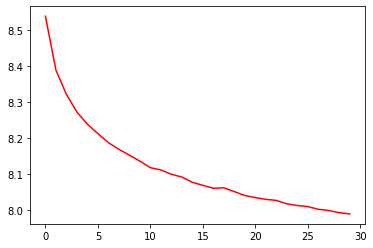

In [20]:
plt.plot(losses, color = 'red')

In [24]:
totalPredictions = 0
correctPredictions = 0
wrongPred1 = []
model.eval()
for xTestBatch, yTestBatch in testLoader :
    yPred = model.predict(xTestBatch)
    correctPredictions += torch.eq(yPred, yTestBatch).sum()
    
    for i, sample in enumerate(yPred, 0) : 
        if(yPred[i] != yTestBatch[i]) :
            wrongPred1.append({'image' : xTestBatch[i].permute(1, 2, 0), 'answer' : yTestBatch[i], 'pred' : yPred[i]})
    totalPredictions += batchSize
print('Accuracy : ', correctPredictions/totalPredictions)

Accuracy :  tensor(0.7057)


In [23]:
model.state_dict()

OrderedDict([('batchNormInput.running_mean',
              tensor([-0.1373, -0.1810, -0.2557])),
             ('batchNormInput.running_var', tensor([0.3011, 0.2870, 0.2988])),
             ('batchNormInput.num_batches_tracked', tensor(93751)),
             ('conv1.weight',
              tensor([[[[-0.1752, -0.2633, -0.1650],
                        [-0.2677, -0.3270, -0.1560],
                        [ 0.1957,  0.4842,  0.6700]],
              
                       [[-0.1364, -0.1735, -0.0083],
                        [-0.1947, -0.0633,  0.2398],
                        [ 0.0787, -0.0060,  0.3019]],
              
                       [[ 0.4287,  0.3913,  0.1384],
                        [ 0.2134, -0.0920, -0.2721],
                        [-0.2630, -0.2559, -0.4016]]],
              
              
                      [[[ 0.0203,  0.0726, -0.0330],
                        [-0.1452, -0.2721, -0.1695],
                        [ 0.1967,  0.0395, -0.0346]],
              
          

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Answer :  cat
Predic :  dog


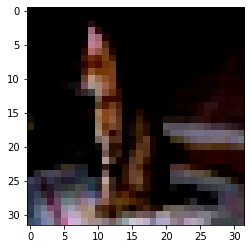

In [30]:
i = 9
plt.imshow(wrongPred1[i]['image'])
print('Answer : ', classes[wrongPred1[i]['answer'].int()])
print('Predic : ', classes[wrongPred1[i]['pred'].int()])

In [75]:
PATH = 'savedModels/' + datetime.now().strftime("%Y_%m_%d-%H:%M:%S") + '.pth'
torch.save({'params' : model.state_dict(), 'losses' : losses}, PATH)